### Import Libraries and Set Direction

In [6]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from nltk.translate.bleu_score import corpus_bleu
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.applications.inception_v3 import InceptionV3

In [7]:
BASE_DIR = ''
WORKING_DIR = ''

The dataset can be downloaded at: https://drive.google.com/drive/folders/1f22r60a-M_m4AvD5mdarOvyAA9r-N5By. The 'Image' folder and captions file need to be saved in the same place as this file.

### Extracting Image Features

In [8]:
# We load the VGG16 model.
vgg16 = VGG16()
# We restructure the model.
vgg16 = Model(inputs=vgg16.inputs, outputs=vgg16.layers[-2].output)

In [9]:
# We load the InceptionV3 model.
inceptionv3 = InceptionV3()
# We restructure the model.
inceptionv3 = Model(inputs=inceptionv3.inputs, outputs=inceptionv3.layers[-2].output)

In [ ]:
# We extract features for the VGG16 model.
VGGFeatures = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # We load the image.
    image_path = directory + '/' + img_name
    image = load_img(image_path, target_size=(224, 224))
    # Convert the image pixels to a numpy array.
    image = img_to_array(image)
    # Reshape the data to fit the model.
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for the VGG model.
    image = preprocess_input(image)
    # Extract the features.
    feature = vgg16.predict(image, verbose=0)
    # Get the image IDs.
    image_id = img_name.split('.')[0]
    # Lastly, store the features.
    VGGFeatures[image_id] = feature

In [ ]:
# We extract features for the InceptionV3 model.
InceptionFeatures = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # We load the image.
    image_path = directory + '/' + img_name
    image = load_img(image_path, target_size=(299, 299))
    # Convert the image pixels to a numpy array.
    image = img_to_array(image)
    # Reshape the data to fit the model.
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess the image for the VGG model.
    image = preprocess_input(image)
    # Extract the features.
    feature = inceptionv3.predict(image, verbose=0)
    # Get the image IDs.
    image_id = img_name.split('.')[0]
    # Lastly, store the features.
    InceptionFeatures[image_id] = feature

In [ ]:
# We store the features in pickle to easily use them again.
pickle.dump(VGGFeatures, open(os.path.join(WORKING_DIR, 'VGG Features.pkl'), 'wb'))
pickle.dump(InceptionFeatures, open(os.path.join(WORKING_DIR, 'VGG Features.pkl'), 'wb'))

In [10]:
# If features are already stored, load them from here!
with open(os.path.join(WORKING_DIR, 'VGG Features.pkl'), 'rb') as f:
    VGGFeatures = pickle.load(f)

with open(os.path.join(WORKING_DIR, 'Inception Features.pkl'), 'rb') as f:
    InceptionFeatures = pickle.load(f)

### Loading Captions Data

In [11]:
# We load the captions file.
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [12]:
# We create mapping of images to captions.
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    # Splitting the lines by comma.
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # Removing the extension from image ID.
    image_id = image_id.split('.')[0]
    # Convert caption list to string.
    caption = " ".join(caption)
    # Create list.
    if image_id not in mapping:
        mapping[image_id] = []
    # Store the captions.
    mapping[image_id].append(caption)
    

  0%|          | 0/40456 [00:00<?, ?it/s]

In [13]:
# Check to see the number of images with captions.
len(mapping)

8091

### Pre-Processing of Text Data

In [14]:
# We define a function to clean the text data.

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            # We convert to lowercase letters.
            caption = caption.lower()
            # Remove digits and special characters. 
            caption = caption.replace('[^A-Za-z]', '')
            # Remove additional spaces.
            caption = caption.replace('\s+', ' ')
            # Add start tags and end tags to captions.
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [15]:
# This is what the captions look like before pre-processing. 
mapping['186346360_541047336f']

['A girl in a bikini top and shorts poses for a picture on a mountain overlooking a lake .',
 'A girl in a bikini top stands in front of a beautiful view .',
 'A girl in a bikini top with a great view in the background',
 'A woman poses for a picture while in front of a lake .',
 'Woman in white bikini top and blue shorts with body of water in the background .']

In [16]:
# We pre-process all the captions.
clean(mapping)

In [17]:
# This is what the captions look like after the pre-processing.
mapping['186346360_541047336f']

['startseq girl in bikini top and shorts poses for picture on mountain overlooking lake endseq',
 'startseq girl in bikini top stands in front of beautiful view endseq',
 'startseq girl in bikini top with great view in the background endseq',
 'startseq woman poses for picture while in front of lake endseq',
 'startseq woman in white bikini top and blue shorts with body of water in the background endseq']

In [18]:
# Storing the pre-processed captions in all_captions.
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [19]:
# Check the number of captions.
len(all_captions)


40455

In [20]:
# We tokenize the text.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
# See the number of unique words.
vocab_size

8485

In [22]:
# We obtain the maximum length of the captions. This is used for padding later.
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

### Train-Test-Split

In [23]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [24]:
# Due to limited memory, we need to define a data generator function to get the data in batches.
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Looping over the images.
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                # We encode the sequence.
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Split the sequence into pairs (X, Y).
                for i in range(1, len(seq)):
                    # Split into input and output.
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad the input sequences.
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Encode the output sequences.
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # Store the sequences.
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

### Model Creation

In [25]:
# Image Feature Layers.
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Text Sequence Feature Layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder Model.
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model1 = Model(inputs=[inputs1, inputs2], outputs=outputs)
model1.compile(loss='categorical_crossentropy', optimizer='adam')

model2 = Model(inputs=[inputs1, inputs2], outputs=outputs)
model2.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
# Now, we train the VGG16 model.
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # We use the previously defined data generator function.
    generator1 = data_generator(train, mapping, VGGFeatures, tokenizer, max_length, vocab_size, batch_size)
    # Fit for one singular epoch.
    model1.fit(generator1, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
# Now, we train the InceptionV3 model.
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # We use the previously defined data generator function.
    generator2 = data_generator(train, mapping, InceptionFeatures, tokenizer, max_length, vocab_size, batch_size)
    # Fit for one singular epoch.
    model2.fit(generator2, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
# We save the models for future use.
model1.save('VGG Model.h5')
model2.save('Inception Model.h5')

In [26]:
# Load the models.
model1 = tf.keras.models.load_model('VGG Model.h5')
model2 = tf.keras.models.load_model('Inception Model.h5')

### Generate Captions for Images

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
# We define a function to generate a caption for an image.
def predict_caption(model, image, tokenizer, max_length):
    # Add a start tag for generation process.
    in_text = 'startseq'
    # Iterate until the maximum length of a sentence.
    for i in range(max_length):
        # Encode input sequence.
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence.
        sequence = pad_sequences([sequence], max_length)
        # Predict the next word.
        yhat = model.predict([image, sequence], verbose=0)
        # Retrieve index with high probability.
        yhat = np.argmax(yhat)
        # Convert the index to word.
        word = idx_to_word(yhat, tokenizer)
        # Stop if a word is not found.
        if word is None:
            break
        # Append the word as input and generate next word.
        in_text += " " + word
        # Stop when we reach the end tag.
        if word == 'endseq':
            break
      
    return in_text

In [29]:
# Define function to test model.

def TestModel(model, features):

    actual, predicted = list(), list()

    for key in tqdm(test):
        # Retrieve the actual captions.
        captions = mapping[key]

        # Predict the caption for the image.
        y_prediction = predict_caption(model, features[key], tokenizer, max_length) 

        # Split the caption into individual words.
        actual_captions = [caption.split() for caption in captions]
        y_prediction = y_prediction.split()

        # Append to the list.
        actual.append(actual_captions)
        predicted.append(y_prediction)

    # We calculate the BLEU score of our model.
    print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [28]:
print('The BLEU scores for the VGG16 model are:')
TestModel(model1, VGGFeatures)

The BLEU scores for the VGG16 model are:


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.543907
BLEU-2: 0.318137


In [29]:
print('The BLEU scores for the InceptionV3 model are:')
TestModel(model2, InceptionFeatures)

The BLEU scores for the InceptionV3 model are:


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.543710
BLEU-2: 0.322505


### Visualize Results

In [30]:
# Define function generate caption for both models.
def caption(image_name):
    
    # Load the image.
    image_id = image_name.split('.')[0]
    image_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(image_path)
    captions = mapping[image_id]

    # Print the actual captions of the image.
    print('Actual Caption:')
    for caption in captions:
        print(caption)

    # We predict the caption for the image.
    y_pred1 = predict_caption(model1, VGGFeatures[image_id], tokenizer, max_length)
    y_pred2 = predict_caption(model2, InceptionFeatures[image_id], tokenizer, max_length)
    print('VGG16:', y_pred1)
    print('InceptionV3:', y_pred2)
    plt.imshow(image)

In [37]:
# Define function to generate caption for new image.
def new_caption(image_name):

    # Load the image.
    image_path = os.path.join("New Images", image_name)
    image = Image.open(image_path)
    plt.imshow(image)

    # We load the image.
    image1 = load_img(image_path, target_size=(224, 224))
    image2 = load_img(image_path, target_size=(299, 299))
    
    # Convert the image pixels to a numpy array.
    image1 = img_to_array(image1)
    image2 = img_to_array(image2)

    # Reshape the data to fit the model.
    image1 = image1.reshape((1, image1.shape[0], image1.shape[1], image1.shape[2]))
    image2 = image2.reshape((1, image2.shape[0], image2.shape[1], image2.shape[2]))

    # Preprocess the image for the VGG model.
    image1 = preprocess_input(image1)
    image2 = preprocess_input(image2)

    # Extract the features.
    feature1 = vgg16.predict(image1, verbose=0)
    feature2 = inceptionv3.predict(image2, verbose=0)

    # We predict the caption for the image.
    y_prediction1 = predict_caption(model1, feature1, tokenizer, max_length)
    y_prediction2 = predict_caption(model2, feature2, tokenizer, max_length)
    print('VGG16:', y_prediction1)
    print('InceptionV3:', y_prediction2)

Actual Caption:
startseq kayaker kayaks through the water endseq
startseq person kayaking in the ocean endseq
startseq person kayaks in the middle of the ocean on grey day endseq
startseq person rows boat over large body of water endseq
startseq person in boat with paddle in hand endseq
VGG16: startseq man in red shirt is waterskiing on the water endseq
InceptionV3: startseq person parasails in the ocean endseq


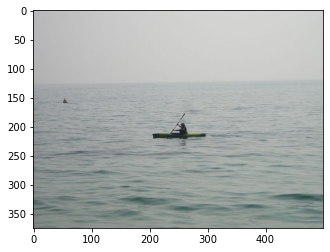

In [38]:
caption("19212715_20476497a3.jpg")

VGG16: startseq baseball player swings his bat to swing endseq
InceptionV3: startseq police police keeps seven seven seven police police police police keeps seven seven seven police police keeps seven seven seven keeps seven seven seven seven keeps seven seven seven seven keeps seven seven seven keeps


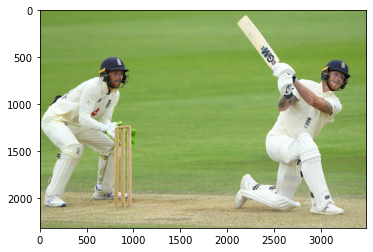

In [39]:
new_caption('cricket.jpg')